In [1]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import re
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ast
from PIL import Image, ImageDraw
import cv2


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Plotting Function
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [3]:
# Function to read in Marks
def read_xml(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return lines

In [4]:
# Get a list of files in Thyroid with Segmentatin Coordinates
filenames = glob.glob("thyroid/*")

In [5]:
# Create List of Images Files
images = [x for x in filenames if x.endswith(".jpg")]

# Create List of Segments
segments = [x for x in filenames if x.endswith(".xml")]

In [6]:
# Create List of Marks
marks = [read_xml(file) for file in segments]

In [7]:
# Initialize a dictionary
temp_dict = {}

# Create a dictionary with img_id as the Key and the Mark as the Values
for i in marks:
    pattern = r"<case>(.*?)</case>"
    temp = re.findall(pattern, str(i))[0]
    
    id_1 = re.findall(r"<number>(.*?)</number>",temp)[0]
    id_2 = re.findall(r"<image>(.*?)</image>",temp)
    
    for t in id_2:
        pattern = r"<image>"+t+"</image><svg>(.*?)</svg>"
        temp_dict[id_1+'_'+t] = re.findall(pattern,temp)

In [8]:
# Create DataFrame from Dictionary
segments = pd.DataFrame.from_dict(temp_dict, orient='index').reset_index()

# Rename columns
segments = segments.rename(columns = {'index':'img_id',0:"mark"})

# Look at df
segments.head()


,img_id,mark
0,1_1,"[{""points"": [{""x"": 385, ""y"": 182}, {""x"": 398, ..."
1,1_2,"[{""points"": [{""x"": 417, ""y"": 155}, {""x"": 418, ..."
2,10_1,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ..."
3,100_1,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""..."
4,101_1,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ..."


In [9]:
# Remove images without a mark
segments = segments[segments['mark']!=""]

In [10]:
# add file path to image id
segments['img_id'] = segments["img_id"].apply(lambda x: "thyroid/"+x+".jpg")

In [11]:
# spot check rows to make sure df is correct
segments['mark'].loc[segments['img_id']=="thyroid/348_1.jpg"].get_values()

array(['[{"points": [{"x": 357, "y": 82}, {"x": 350, "y": 82}, {"x": 342, "y": 85}, {"x": 335, "y": 94}, {"x": 330, "y": 114}, {"x": 338, "y": 138}, {"x": 358, "y": 156}, {"x": 368, "y": 163}, {"x": 381, "y": 162}, {"x": 392, "y": 144}, {"x": 398, "y": 130}, {"x": 398, "y": 111}, {"x": 390, "y": 97}, {"x": 375, "y": 87}, {"x": 364, "y": 81}, {"x": 358, "y": 79}], "annotation": {}, "regionType": "freehand"}, {"points": [{"x": 357, "y": 82}, {"x": 350, "y": 82}, {"x": 342, "y": 85}, {"x": 335, "y": 94}, {"x": 330, "y": 114}, {"x": 338, "y": 138}, {"x": 358, "y": 156}, {"x": 368, "y": 163}, {"x": 381, "y": 162}, {"x": 392, "y": 144}, {"x": 398, "y": 130}, {"x": 398, "y": 111}, {"x": 390, "y": 97}, {"x": 375, "y": 87}, {"x": 364, "y": 81}, {"x": 358, "y": 79}], "annotation": {}, "regionType": "freehand"}, {"points": [{"x": 357, "y": 82}, {"x": 350, "y": 82}, {"x": 342, "y": 85}, {"x": 335, "y": 94}, {"x": 330, "y": 114}, {"x": 338, "y": 138}, {"x": 358, "y": 156}, {"x": 368, "y": 163}, {"x

In [12]:
# Remove images in which the data does not make sense
pattern = r'"points"(.*?)"annotation"'
segments = segments[segments["mark"].apply(lambda x: len(re.findall(pattern, x))<=2)]

In [13]:
# Prepare data for test plot

test = segments.loc[segments['img_id']=="thyroid/88_1.jpg"]
l = test['mark'].get_values()[0]

i = 0
t = 0

test_1 = re.findall(r'\d+', l)

dims = len(test_1)//2

temp = np.empty([dims, 2])
temp

while i < dims:
    temp[i] = (test_1[t], test_1[t+1])
    i = i+1
    t = t+2


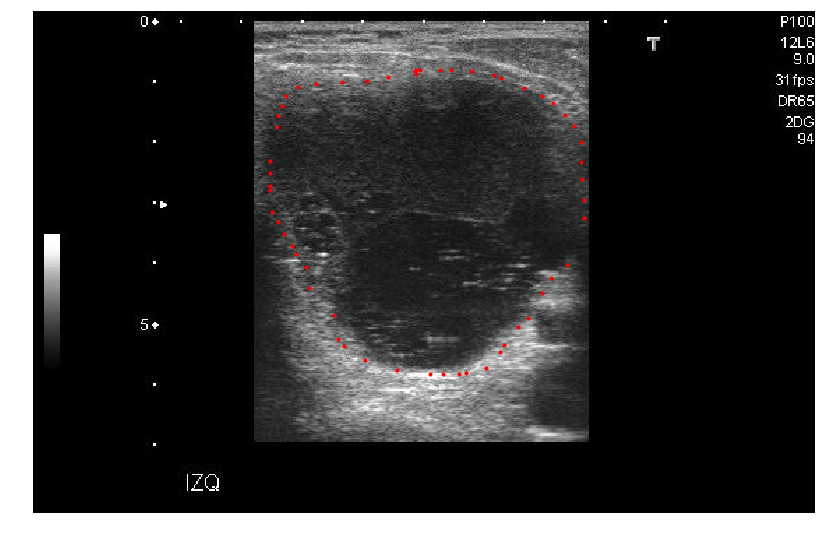

In [14]:
# Create Plot

fig, ax = image_show(Image.open('thyroid/88_1.jpg'), cmap='gray')
ax.plot(temp[:, 0], temp[:, 1], '.r',lw=3)

In [15]:
# Break up Marks

pattern = r'"points"(.*?)"annotation"'
segments["mark_1"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[0])
segments["mark_2"] = segments["mark"].apply(lambda x: re.findall(pattern, x)[1] if len(re.findall(pattern, x)) > 1 else "")

In [16]:
segments.head()

,img_id,mark,mark_1,mark_2
0,thyroid/1_1.jpg,"[{""points"": [{""x"": 385, ""y"": 182}, {""x"": 398, ...",": [{""x"": 385, ""y"": 182}, {""x"": 398, ""y"": 179},...",
1,thyroid/1_2.jpg,"[{""points"": [{""x"": 417, ""y"": 155}, {""x"": 418, ...",": [{""x"": 417, ""y"": 155}, {""x"": 418, ""y"": 76}, ...",
2,thyroid/10_1.jpg,"[{""points"": [{""x"": 326, ""y"": 172}, {""x"": 332, ...",": [{""x"": 326, ""y"": 172}, {""x"": 332, ""y"": 172},...",
3,thyroid/100_1.jpg,"[{""points"": [{""x"": 164, ""y"": 31}, {""x"": 159, ""...",": [{""x"": 164, ""y"": 31}, {""x"": 159, ""y"": 31}, {...",": [{""x"": 381, ""y"": 24}, {""x"": 370, ""y"": 28}, {..."
4,thyroid/101_1.jpg,"[{""points"": [{""x"": 224, ""y"": 156}, {""x"": 224, ...",": [{""x"": 224, ""y"": 156}, {""x"": 224, ""y"": 147},...",": [{""x"": 462, ""y"": 157}, {""x"": 462, ""y"": 152},..."


In [17]:
# Create temp dataframes and concat

temp_1 = segments[["img_id","mark_1"]].copy()
temp_2 = segments[["img_id","mark_2"]].copy()

temp_1=temp_1.rename(columns = {'mark_1':'mark'})
temp_2=temp_2.rename(columns = {'mark_2':'mark'})

frames = [temp_1, temp_2]

df_new = pd.concat(frames,ignore_index = True)
df_new.head()

,img_id,mark
0,thyroid/1_1.jpg,": [{""x"": 385, ""y"": 182}, {""x"": 398, ""y"": 179},..."
1,thyroid/1_2.jpg,": [{""x"": 417, ""y"": 155}, {""x"": 418, ""y"": 76}, ..."
2,thyroid/10_1.jpg,": [{""x"": 326, ""y"": 172}, {""x"": 332, ""y"": 172},..."
3,thyroid/100_1.jpg,": [{""x"": 164, ""y"": 31}, {""x"": 159, ""y"": 31}, {..."
4,thyroid/101_1.jpg,": [{""x"": 224, ""y"": 156}, {""x"": 224, ""y"": 147},..."


In [18]:
# Remove empty rows
df_new = df_new[df_new['mark']!=""]

In [19]:
df_new = df_new[~df_new.img_id.str.contains('338_2')]
df_new = df_new[~df_new.img_id.str.contains('571_2')]
df_new = df_new[~df_new.img_id.str.contains('358_1')]
df_new = df_new[~df_new.img_id.str.contains('362_1')]
df_new = df_new[~df_new.img_id.str.contains('378_1')]
df_new = df_new[~df_new.img_id.str.contains('384_1')]
df_new = df_new[~df_new.img_id.str.contains('399_1')]

In [20]:
# Function to parse marks

def parse_mark(mark):
    i = 0
    t = 0
    test_1 = re.findall(r'\d+', mark)
    dims = len(test_1)//2
    temp = np.empty([dims, 2])
    
    while i < dims:
        temp[i] = (test_1[t], test_1[t+1])
        i = i+1
        t = t+2
        
    return temp


In [21]:
# Parse Marks

df_new['mark'] = df_new['mark'].apply(lambda x: parse_mark(x))

In [22]:
df_new.head()

,img_id,mark
0,thyroid/1_1.jpg,"[[385.0, 182.0], [398.0, 179.0], [404.0, 176.0..."
1,thyroid/1_2.jpg,"[[417.0, 155.0], [418.0, 76.0], [413.0, 73.0],..."
2,thyroid/10_1.jpg,"[[326.0, 172.0], [332.0, 172.0], [341.0, 172.0..."
3,thyroid/100_1.jpg,"[[164.0, 31.0], [159.0, 31.0], [141.0, 33.0], ..."
4,thyroid/101_1.jpg,"[[224.0, 156.0], [224.0, 147.0], [226.0, 140.0..."


In [23]:
#Create file name columand and Segregate Duplicates
df = df_new.copy()
df['name'] = df['img_id'].apply(lambda x: x.replace('thyroid/',''))
df.index = range(len(df))
d = df.duplicated(subset=['name'], keep='first')
df_mrk1 = df[-d]
df_mrk2 = df[d]


In [24]:
#Create mark 1 outlines
df_mrk1.index = range(len(df_mrk1.index))
seg_coords = df_mrk1['mark']
seg_file = df_mrk1['name'].apply(lambda x: x.replace('.jpg',''))

#Build annotated images from mark feature data
for i in range(seg_coords.size):
    seg_coord = seg_coords[i]
    #Create blank image
    ann_img = np.zeros((560,360,3))
    for coord in seg_coord:
        #sets pixel (x,y,:) to (255,255,255) based on coordinates
        ann_img[int(coord[0]),-int(coord[1]),:] = 255
    #Write to new image file and save
    basepath = "./data/single_seg_outline/"
    cv2.imwrite(basepath+seg_file[i]+".png",ann_img)
    
#rotate image 90 degrees counter clockwise
for i in range(seg_coords.size):
    img = cv2.imread(basepath+seg_file[i]+".png")
    img = cv2.transpose(img);
    img = cv2.flip( img,0 )
    cv2.imwrite(basepath+seg_file[i]+".png",img)

#Create mark 2 outlines
df_mrk2.index = range(len(df_mrk2.index))
seg_coords = df_mrk2['mark']
seg_file = df_mrk2['name'].apply(lambda x: x.replace('.jpg','_dup'))

#Build annotated images from mark feature data
for i in range(seg_coords.size):
    seg_coord = seg_coords[i]
    #Create blank image
    ann_img = np.zeros((560,360,3))
    for coord in seg_coord:
        #sets pixel (x,y,:) to (255,255,255) based on coordinates
        ann_img[int(coord[0]),-int(coord[1]),:] = 255
    #Write to new image file and save
    basepath = "./data/single_seg_outline/"
    cv2.imwrite(basepath+seg_file[i]+".png",ann_img)
    
#rotate image 90 degrees counter clockwise
for i in range(seg_coords.size):
    img = cv2.imread(basepath+seg_file[i]+".png")
    img = cv2.transpose(img);
    img = cv2.flip( img,0 )
    cv2.imwrite(basepath+seg_file[i]+".png",img)


In [25]:
#Overlay multiple segmentations in single image
seg_file = df_mrk2['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
basepath = "./data/single_seg_outline/"
for i in range(len(seg_list)):
    background = cv2.imread(basepath+seg_list[i]+".png")
    overlay = cv2.imread(basepath+seg_list[i]+'_dup'+".png")
    ovrly_image = cv2.addWeighted(background,0.5,overlay,0.5,0)
    cv2.imwrite("./data/multi_seg_outline/"+seg_list[i]+".png",ovrly_image)

In [26]:
#Overlay single segmentation coords on top of original image
seg_file = df_mrk1['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
basepath = "./data/single_seg_outline/"
for i in range(len(seg_list)):
    background = cv2.imread("./thyroid/"+seg_list[i]+".jpg")
    overlay = cv2.imread(basepath+seg_list[i]+".png")
    ovrly_image = cv2.addWeighted(background,0.4,overlay,0.8,0)
    cv2.imwrite("./data/overlay/"+seg_list[i]+".png",ovrly_image)

In [27]:
#Overlay multi segmentation coords on top of original image
seg_file = df_mrk2['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
basepath = "./data/multi_seg_outline/"
for i in range(len(seg_list)):
    background = cv2.imread("./thyroid/"+seg_list[i]+".jpg")
    overlay = cv2.imread(basepath+seg_list[i]+".png")
    ovrly_image = cv2.addWeighted(background,0.4,overlay,0.8,0)
    cv2.imwrite("./data/outlines/"+seg_list[i]+".png",ovrly_image)

In [28]:
#Build mask for single segmentation
seg_coords = df_mrk1['mark']
seg_file = df_mrk1['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
for i in range(len(seg_list)):
    seg_coord = seg_coords[i]
    #Create blank image
    lis = []
    for coord in seg_coord:
        lis.append(coord[0])
        lis.append(coord[1])
    polygon = lis
    img = Image.new('L', (560, 360), 255)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    basepath = "./data/single_seg_masks/"
    cv2.imwrite(basepath+seg_file[i]+".png",mask)

In [29]:
#Build mask for multi segmentation
seg_coords = df_mrk2['mark']
seg_file = df_mrk2['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
for i in range(len(seg_list)):
    seg_coord = seg_coords[i]
    #Create blank image
    lis = []
    for coord in seg_coord:
        lis.append(coord[0])
        lis.append(coord[1])
    polygon = lis
    img = Image.new('L', (560, 360), 255)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    basepath = "./data/multi_seg_masks/"
    cv2.imwrite(basepath+seg_file[i]+".png",mask)

In [30]:
#Overlay multiple segmentations in single image
seg_file = df_mrk2['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
basepath1 = "./data/single_seg_masks/"
basepath2 = "./data/multi_seg_masks/"
for i in range(len(seg_list)):
    background = cv2.imread(basepath1+seg_list[i]+".png")
    overlay = cv2.imread(basepath2+seg_list[i]+".png")
    ovrly_image = cv2.addWeighted(background,0.5,overlay,0.5,0)
    im_bw = cv2.threshold(ovrly_image, 200, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite("./data/masks/"+seg_list[i]+".png",im_bw)
    

In [31]:
#Move single segmentation masks to folder with multisegmentation masks
import os
import shutil

#change .jpg to .png
df['name'] = df['name'].apply(lambda x: x.replace('.jpg','.png'))
#find list of single segmentation images
all_list = list(df[-d]['name'])
dup_list = list(df[d]['name'])
single_list = list(set(all_list).difference(dup_list))

start_base_filepath = "./data/single_seg_masks/"

end_base_filepath = "./data/masks/"
for file in single_list:
    shutil.copyfile(start_base_filepath+file, end_base_filepath+file)


In [32]:
#Invert Masks
seg_file = df_mrk1['name'].apply(lambda x: x.replace('.jpg',''))
seg_list = list(seg_file)
basepath1 = "./data/masks/"
basepath2 = "./data/masks_inverted/"
for i in range(len(seg_list)):
    img = cv2.imread(basepath1+seg_list[i]+".png")
    img = np.invert(img) 
    cv2.imwrite(basepath2+seg_list[i]+".png",img)

In [33]:
#Copy images to image folder and convert to gray
from skimage import io
seg_file = df_mrk1['name']
dest_file = list(df_mrk1['name'].apply(lambda x: x.replace('.jpg','.png')))
basepath1 = "./thyroid/"
basepath2 = "./data/images/"

seg_list = list(seg_file)
for i in range(len(seg_list)):
    shutil.copyfile(basepath1+seg_list[i], basepath2+dest_file[i])

#Convert images to gray
for dest in dest_file:
    img = Image.open(basepath2+file).convert('L')
    img.save(basepath2+file)  

In [34]:
#Test image size
img = Image.open(basepath2+'1_1.png')
img.size

(560, 360)

In [35]:
#Resize Images
#Copy images from image folder, square and resize
seg_file = df_mrk1['name']
dest_file = list(df_mrk1['name'].apply(lambda x: x.replace('.jpg','.png')))
basepath = "./data/images/"

#Square and resize images
for dest in dest_file:
    img= io.imread(basepath + dest)
    img=img[20:276,152:408]
    io.imsave(basepath + dest,img)
    #im = cv2.copyMakeBorder(im,0,200,0,0,cv2.BORDER_CONSTANT)
    #im = im.resize((128,128))






In [36]:
#Resize Labels
#Copy images from image folder, square and resize
seg_file = df_mrk1['name']
dest_file = list(df_mrk1['name'].apply(lambda x: x.replace('.jpg','.png')))
basepath = "./data/masks_inverted/"

#Square and resize images
for dest in dest_file:
    img= io.imread(basepath + dest)
    img=img[20:276,152:408]
    io.imsave(basepath + dest,img)
    #im = cv2.copyMakeBorder(im,0,200,0,0,cv2.BORDER_CONSTANT)
    #im = im.resize((128,128))




In [37]:
#Randomly select images for training, validation and testing
import os
import shutil
import random

filenames = list(df_mrk1['name'].apply(lambda x: x.replace('.jpg','')))
random.seed(0)
random.shuffle(filenames)  # randomly shuffles the ordering of filenames

split_1 = int(0.8 * len(filenames))
split_2 = int(0.9 * len(filenames))
train_filenames = filenames[:split_1]
valid_filenames = filenames[split_1:split_2]
test_filenames = filenames[split_2:]

#images
start_base_filepath = "./data/images/"

end_base_filepath = "./unet/data/train/image/"
for file in train_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+file+".png")
    
end_base_filepath = "./unet/data/valid/image/"
for file in valid_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+file+".png")

end_base_filepath = "./unet/data/test/image/"
i = 0
for file in test_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+str(i)+".png")
    i = i+1
    
#Labels
start_base_filepath = "./data/masks_inverted/"

end_base_filepath = "./unet/data/train/label/"
for file in train_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+file+".png")
    
end_base_filepath = "./unet/data/valid/label/"
for file in valid_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+file+".png")

end_base_filepath = "./unet/data/test/label/"
i = 0
for file in test_filenames:
    shutil.copyfile(start_base_filepath+file+".png", end_base_filepath+str(i)+".png")
    i = i+1

In [232]:
##########################################################################33
basepath = "./unet/data/test/image/"

#Resize prediction images
for i in range(47):
    im = Image.open(basepath + str(i) + '_predict.tif')
    im = im.resize((120,120))
    im.save(basepath + str(i) + '_predict.tif')

In [233]:
#Test image size
#img = Image.open("./unet/data/train/label/"+'1_2.png')
#img = io.imread("./unet/data/train/label/"+'1_2.png')
#img = Image.open("./unet-master/data/membrane/train/image/"+'0.png')
#np.max(img)
#img = np.asarray(img)
#np.max(img)
#img = img /255.
#img[img > 0.5] = 1
#img[img <= 0.5] = 0
#np.max(img)

In [119]:
#img = Image.open('./data/masks_inverted/'+'10_1.png')
img = Image.open('./unet/data/test/image/'+'0_predict.png')
print(np.max(img),np.min(img))
img = np.array(img)
img.shape

0 0


(256, 256)

In [117]:
import pandas as pd
img_df= pd.DataFrame(img[:,:,0])
img_df.to_csv('img_df.csv')